#  Learn Modulation and Bit-Wise Demodulation in the AWGN Channel with Deep Neural Networks by Autoencoders and End-to-end Training

This code is provided as supplementary material of the article "2023 Roadmap on Optical Communications".<br>

This code illustrates
* End-to-end-learning of modulation scheme and demodulator in an AWGN channel with binary autoencoder

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


### Helper function to compute the Bit Error Rate (BER)

In [2]:
# helper function to compute the bit error rate
def BER(predictions, labels):
    return np.mean(1-np.isclose((predictions > 0.5).astype(float), labels))

### Define Parameters

Here, we consider the simple AWGN channel. We modulate using a constellation with $M = 2^m$ different symbol. To symbol $i$, we assign the binary representation of $i$ as bit pattern.

In [8]:
# number of bits assigned to symbol
m = 5

# number of symbols
M = 2**m


EbN0 = 10

# noise standard deviation
sigma_n = np.sqrt((1/2/np.log2(M)) * 10**(-EbN0/10))

# noise deviation of residual phase noise
sigma_r = 0.1

Here, we define the parameters of the neural network and training, generate the validation set and a helping set to show the decision regions

In [4]:
# Bit representation of symbols
binaries = torch.from_numpy(np.reshape(np.unpackbits(np.uint8(np.arange(0,2**m))), (-1,8))).float().to(device)
binaries = binaries[:,(8-m):]

# validation set. Training examples are generated on the fly
N_valid = 100000

# number of neurons in hidden layers at receiver
hidden_neurons_RX_1 = 50
hidden_neurons_RX_2 = 128
hidden_neurons_RX = [hidden_neurons_RX_1, hidden_neurons_RX_2]

# Generate Validation Data
y_valid = np.random.randint(M,size=N_valid)
y_valid_onehot = np.eye(M)[y_valid]
y_valid_binary = binaries[y_valid,:].detach().cpu().numpy()

### Define the architecture of the autoencoder, i.e. the neural network

This is the main neural network/Autoencoder with transmitter, channel and receiver. Transmitter and receiver each with ELU activation function. Note that the final layer does *not* use a `softmax` function, as this function is already included in the `CrossEntropyLoss`.

In [55]:
class Autoencoder(nn.Module):
    def __init__(self, hidden_neurons_RX):
        super(Autoencoder, self).__init__()
        
        # Define Transmitter Layer: Linear function, M input neurons (symbols), 2 output neurons (real and imaginary part)        
        self.fcT = nn.Linear(M, 2) 
        
        # Define Receiver Layer: Linear function, 2 input neurons (real and imaginary part), m output neurons (bits)
        self.fcR1 = nn.Linear(2,hidden_neurons_RX[0]) 
        self.fcR2 = nn.Linear(hidden_neurons_RX[0], hidden_neurons_RX[1]) 
        self.fcR3 = nn.Linear(hidden_neurons_RX[1], m) 

        # Non-linearity (used in transmitter and receiver)
        self.activation_function = nn.ELU()      
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # compute output
        encoded = self.network_transmitter(x)
        
        # compute normalization factor and normalize channel output
        norm_factor = torch.sqrt(torch.mean(torch.mul(encoded,encoded)) * 2 )                            
        modulated = encoded / norm_factor    
        received = self.channel_model(modulated)
        
        bitprob = self.network_receiver(received)
        return bitprob
        
    def network_transmitter(self,batch_labels):
        return self.fcT(batch_labels)
    
    def network_receiver(self,inp):
        out = self.activation_function(self.fcR1(inp))
        out = self.activation_function(self.fcR2(out))
        logits = self.sigmoid(self.fcR3(out))        
        return logits
    
    def channel_model(self,modulated):
        # first add noise, nothing else
        temp = torch.add(modulated, sigma_n*torch.randn(len(modulated),2).to(device))
        
        # add residual phase noise
        phase_noise = sigma_r * torch.randn(len(modulated)).to(device)
                
        received = torch.stack((temp[:,0] * torch.cos(phase_noise) - temp[:,1] * torch.sin(phase_noise), temp[:,0] * torch.sin(phase_noise) + temp[:,1] * torch.cos(phase_noise)), dim = 1)
        return received

### Train the NN and evaluate it at the end of each epoch

Here the idea is to vary the batch size during training. In the first iterations, we start with a small batch size to rapidly get to a working solution. The closer we come towards the end of the training we increase the batch size. If keeping the batch size small, it may happen that there are no misclassifications in a small batch and there is no incentive of the training to improve. A larger batch size will most likely contain errors in the batch and hence there will be incentive to keep on training and improving. 

Here, the data is generated on the fly inside the graph, by using PyTorch random number generation. As PyTorch does not natively support complex numbers (at least in early versions), we decided to replace the complex number operations in the channel by a simple rotation matrix and treating real and imaginary parts separately.

We use the ELU activation function inside the neural network and employ the Adam optimization algorithm.

Now, carry out the training as such. First initialize the variables and then loop through the training. Here, the epochs are not defined in the classical way, as we do not have a training set per se. We generate new data on the fly and never reuse data. We change the batch size in each epoch.<br>

To get the constellation symbols and the received data, we apply the model after each epoch.

In [56]:
model = Autoencoder(hidden_neurons_RX)
model.to(device)

    
loss_fn = nn.BCELoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters())  


# Training parameters
num_epochs = 150
batches_per_epoch = np.linspace(1, 1000, num=num_epochs).astype(int)

# Vary batch size during training
batch_size_per_epoch = np.linspace(200,5000,num=num_epochs)
learning_rate_per_epoch = np.linspace(0.001, 0.00001, num=num_epochs)

validation_BERs = np.zeros(num_epochs)
validation_received = []
constellations = []

print('Start Training')
for epoch in range(num_epochs):
    
    batch_labels = torch.empty(int(batch_size_per_epoch[epoch]), device=device)
    batch_labels_binary = torch.zeros(int(batch_size_per_epoch[epoch]), m, device=device)
        
    
    for step in range(batches_per_epoch[epoch]):
        # Generate training data: In most cases, you have a dataset and do not generate a training dataset during training loop
        # sample new mini-batch directory on the GPU (if available)        
        batch_labels.random_(M)
        batch_labels_onehot = torch.zeros(int(batch_size_per_epoch[epoch]), M, device=device)
        batch_labels_onehot[range(batch_labels_onehot.shape[0]), batch_labels.long()]=1

        batch_labels_binary[range(batch_labels_onehot.shape[0]), :] = binaries[batch_labels.long(),:]

        
        # Propagate (training) data through the net
        NN_output = model(batch_labels_onehot)

        # compute loss
        loss = loss_fn(NN_output, batch_labels_binary)

        # compute gradients
        loss.backward()
        
        # Adapt weights
        optimizer.step()
        
        # reset gradients
        optimizer.zero_grad()
        
    optimizer.param_groups[0]['lr'] = learning_rate_per_epoch[epoch]
    
    # compute validation BER
    out_valid = model(torch.Tensor(y_valid_onehot).to(device))
    validation_BERs[epoch] = BER(out_valid.detach().cpu().numpy(), y_valid_binary)
    print('Validation BER after epoch %d: %f (loss %1.8f)' % (epoch, validation_BERs[epoch], loss.detach().cpu().numpy()))                

     # calculate and store received validation data
    encoded = model.network_transmitter(torch.Tensor(y_valid_onehot).to(device))
    norm_factor = torch.sqrt(torch.mean(torch.mul(encoded,encoded)) * 2 )                          
    modulated = encoded / norm_factor    
    received = model.channel_model(modulated)
    validation_received.append(received.detach().cpu().numpy())
    
    # calculate and store constellation
    encoded = model.network_transmitter(torch.eye(M).to(device))
    norm_factor = torch.sqrt(torch.mean(torch.mul(encoded,encoded)) * 2 )                            
    modulated = encoded / norm_factor 
    constellations.append(modulated.detach().cpu().numpy())

    
print('Training finished')

Start Training
Validation BER after epoch 0: 0.497104 (loss 0.69889629)
Validation BER after epoch 1: 0.424828 (loss 0.68722695)
Validation BER after epoch 2: 0.383556 (loss 0.66317296)
Validation BER after epoch 3: 0.351420 (loss 0.60582072)
Validation BER after epoch 4: 0.310486 (loss 0.52797395)
Validation BER after epoch 5: 0.270914 (loss 0.44342795)
Validation BER after epoch 6: 0.236058 (loss 0.38666674)
Validation BER after epoch 7: 0.185644 (loss 0.34281117)
Validation BER after epoch 8: 0.147720 (loss 0.27631852)
Validation BER after epoch 9: 0.101648 (loss 0.21044521)
Validation BER after epoch 10: 0.069424 (loss 0.15264873)
Validation BER after epoch 11: 0.051958 (loss 0.13287632)
Validation BER after epoch 12: 0.039626 (loss 0.12206197)
Validation BER after epoch 13: 0.034592 (loss 0.10946046)
Validation BER after epoch 14: 0.035300 (loss 0.10157874)
Validation BER after epoch 15: 0.031160 (loss 0.08870360)
Validation BER after epoch 16: 0.030860 (loss 0.08623604)
Validatio

Validation BER after epoch 141: 0.018332 (loss 0.04722489)
Validation BER after epoch 142: 0.017806 (loss 0.05121915)
Validation BER after epoch 143: 0.018450 (loss 0.04739399)
Validation BER after epoch 144: 0.018016 (loss 0.04730428)
Validation BER after epoch 145: 0.018388 (loss 0.04659101)
Validation BER after epoch 146: 0.017958 (loss 0.04847778)
Validation BER after epoch 147: 0.017966 (loss 0.04725357)
Validation BER after epoch 148: 0.017922 (loss 0.04732799)
Validation BER after epoch 149: 0.017768 (loss 0.04624471)
Training finished


### Evaluate results

Plt decision region and scatter plot of the validation set. Note that the validation set is **only** used for computing SERs and plotting, there is no feedback towards the training!

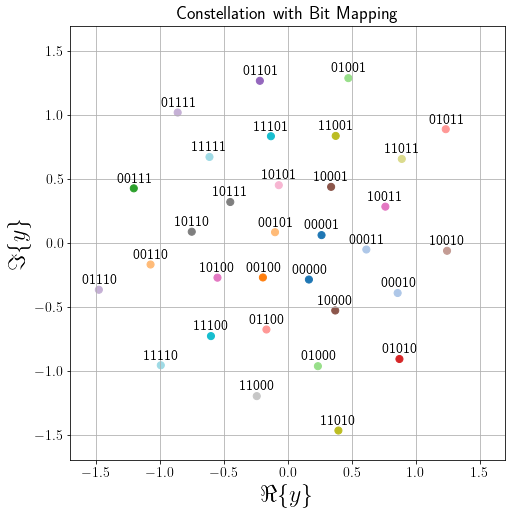

In [60]:
cmap = matplotlib.cm.tab20
base = plt.cm.get_cmap(cmap)
color_list = base.colors
new_color_list = [[t/2 + 0.5 for t in color_list[k]] for k in range(len(color_list))]

# find minimum SER from validation set
min_BER_iter = np.argmin(validation_BERs)

plt.figure(figsize=(10,8))
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))

bin_labels = [np.binary_repr(j).zfill(m) for j in range(2**m)]

   
plt.scatter(constellations[min_BER_iter][:,0], constellations[min_BER_iter][:,1], c=range(M), cmap='tab20',s=50)
for i, txt in enumerate(bin_labels):
    plt.annotate(txt, xy=(constellations[min_BER_iter][i,0], constellations[min_BER_iter][i,1]), xycoords='data', \
                      xytext=(0, 3), textcoords='offset points', \
                      ha='center', va='bottom')
    
plt.axis('scaled')
plt.xlabel(r'$\Re\{y\}$',fontsize=24)
plt.ylabel(r'$\Im\{y\}$',fontsize=24)
plt.xlim((-1.7, +1.7))
plt.ylim((-1.7, +1.7))
plt.grid(which='both')
plt.title('Constellation with Bit Mapping',fontsize=18)
plt.savefig('learning_AWGN_BitAE_EbN0%1.1f_M%d.pdf' % (EbN0,M),bbox_inches='tight')

Text(0.5, 1.0, 'Received')

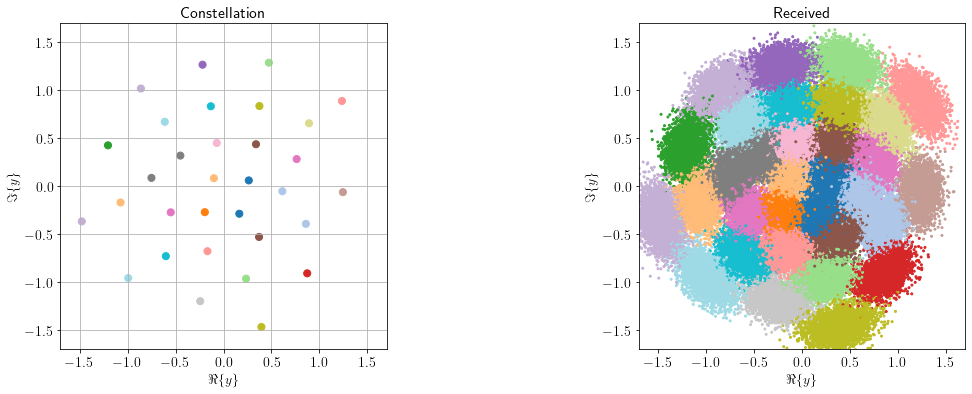

In [58]:
%matplotlib inline
plt.figure(figsize=(19,6))
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))
    
plt.subplot(121)
plt.scatter(constellations[min_BER_iter][:,0], constellations[min_BER_iter][:,1], c=range(M), cmap='tab20',s=50)
plt.axis('scaled')
plt.xlabel(r'$\Re\{y\}$',fontsize=14)
plt.ylabel(r'$\Im\{y\}$',fontsize=14)
plt.xlim((-1.7, +1.7))
plt.ylim((-1.7, +1.7))
plt.grid(which='both')
plt.title('Constellation',fontsize=16)

plt.subplot(122)
#plt.contourf(mgx,mgy,decision_region_evolution[-1].reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.7)
plt.scatter(validation_received[min_BER_iter][:,0], validation_received[min_BER_iter][:,1], c=y_valid, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{y\}$',fontsize=14)
plt.ylabel(r'$\Im\{y\}$',fontsize=14)
plt.xlim((-1.7, +1.7))
plt.ylim((-1.7, +1.7))
plt.title('Received',fontsize=16)

### Generate animation and save as a gif. (Evaluate results III)

<IPython.core.display.Javascript object>


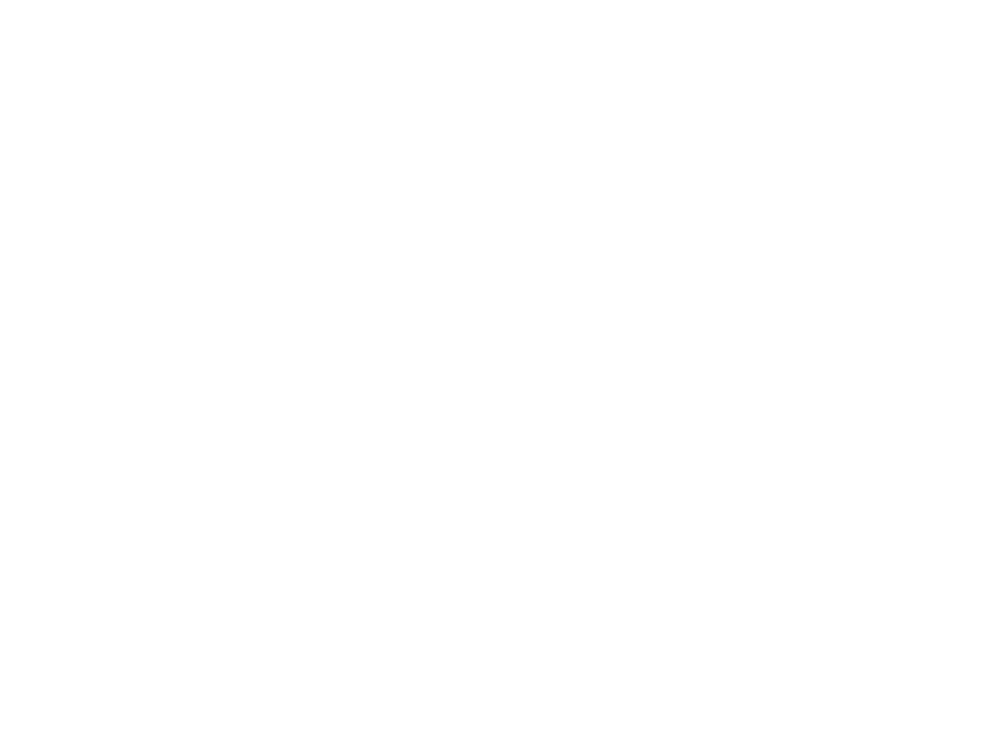

<IPython.core.display.Javascript object>


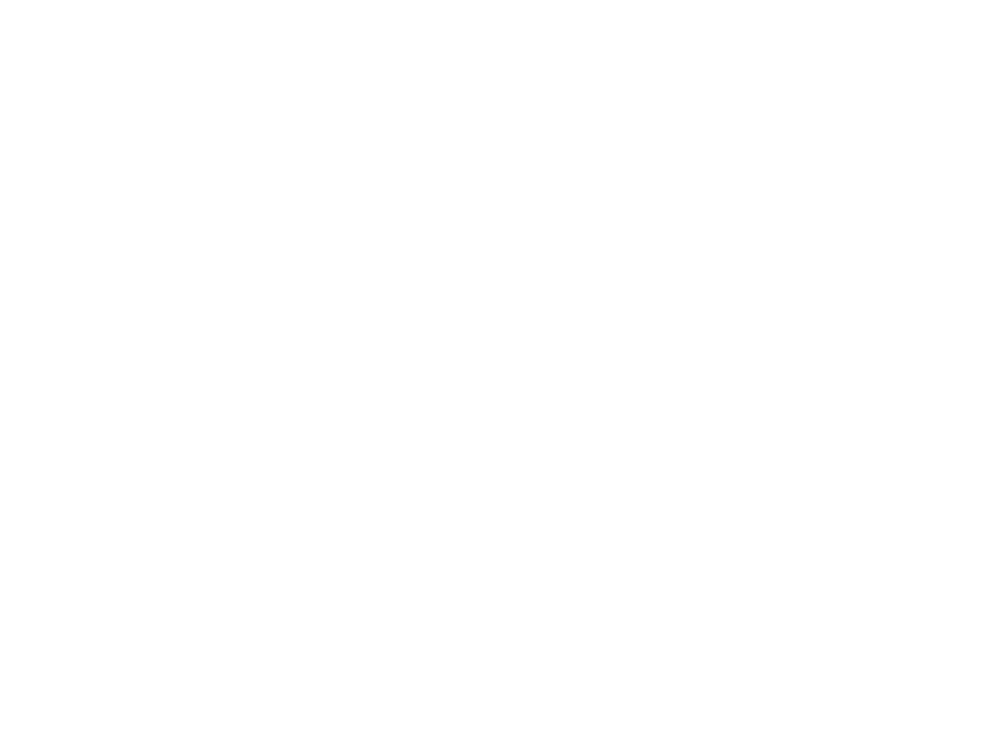

In [61]:
%matplotlib notebook
%matplotlib notebook
# Generate animation
from matplotlib import animation, rc
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.

font = {'size'   : 18}
plt.rc('font', **font)

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)

ax1.axis('scaled')

written = False
def animate(i):
    ax1.clear()
    ax1.scatter(constellations[i][:,0], constellations[i][:,1], c=range(M), cmap='tab20',s=50)

    for j, txt in enumerate(bin_labels):
        ax1.annotate(txt, xy=(constellations[i][j,0], constellations[i][j,1]), xycoords='data', \
                      xytext=(0, 3), textcoords='offset points', \
                      ha='center', va='bottom', fontsize=12)
    
    
    ax1.set_xlim(( -1.7, +1.7))
    ax1.set_ylim(( -1.7, +1.7))
    ax1.set_title('Constellation', fontsize=18)
    
    ax1.set_xlabel(r'$\Re\{y\}$',fontsize=16)
    ax1.set_ylabel(r'$\Im\{y\}$',fontsize=16)

    
anim = animation.FuncAnimation(fig, animate, frames=min_BER_iter+1, interval=200, blit=False)
fig.show()
anim.save('learning_AWGN_BitAE_EbN0%1.1f_M%d.gif' % (EbN0,M), writer=PillowWriter(fps=5))